# Proyek Klasifikasi Gambar: Animal Faces (Cat, Dog, Wild)

- **Nama:** Firda Humaira
- **Email:** firdahumaira13@gmail.com
- **ID Dicoding:** firdahum

### **Sumber Dataset yang saya pakai :**
(https://www.kaggle.com/datasets/andrewmvd/animal-faces?resource=download)

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
#!/bin/bash
!curl -L -o animal-faces.zip\
  'https://www.kaggle.com/api/v1/datasets/download/andrewmvd/animal-faces'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  695M  100  695M    0     0  35.7M      0  0:00:19  0:00:19 --:--:-- 39.7M


In [ ]:
import zipfile

with zipfile.ZipFile('/content/animal-faces.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

### Gabungkan Data Train dan Data Val ke Direktori yang Sama

In [ ]:
# Path asal dan tujuan
source_dir = '/content/afhq'
target_dir = '/content/folder_dataset'

# Buat folder tujuan
os.makedirs(target_dir, exist_ok=True)

# Gabungkan folder train dan val
splits = ['train', 'val']
for split in splits:
    split_path = os.path.join(source_dir, split)

    if os.path.exists(split_path):
        for class_name in os.listdir(split_path):
            src_class_dir = os.path.join(split_path, class_name)
            dst_class_dir = os.path.join(target_dir, class_name)
            os.makedirs(dst_class_dir, exist_ok=True)

            for file_name in os.listdir(src_class_dir):
                shutil.copy2(os.path.join(src_class_dir, file_name),
                             os.path.join(dst_class_dir, file_name))
    else:
        print(f"{split_path} tidak ditemukan.")

print("Gambar dari train dan val berhasil digabung.")

Gambar dari train dan val berhasil digabung.


### Menjadikan satu folder

In [ ]:
# Path folder asal (berisi subfolder per kelas)
source_dir = Path('/content/folder_dataset')
# Path folder tujuan (semua gambar dikumpulkan jadi satu)
flat_target_dir = Path('/content/dataset')

# Pastikan folder tujuan ada
flat_target_dir.mkdir(parents=True, exist_ok=True)

# Loop melalui setiap kelas di folder sumber
for class_dir in source_dir.iterdir():
    if class_dir.is_dir():
        # Loop semua file dalam folder kelas
        for file_path in class_dir.iterdir():
            if file_path.is_file():
                # Buat nama baru dengan prefix nama kelas
                new_name = f"{class_dir.name}_{file_path.name}"
                dst_file = flat_target_dir / new_name

                # Salin file ke folder datar
                shutil.copy2(file_path, dst_file)

print("Semua gambar berhasil dipindahkan ke satu folder.")

Semua gambar berhasil dipindahkan ke satu folder.


### Plot gambar sampel untuk semua kelas

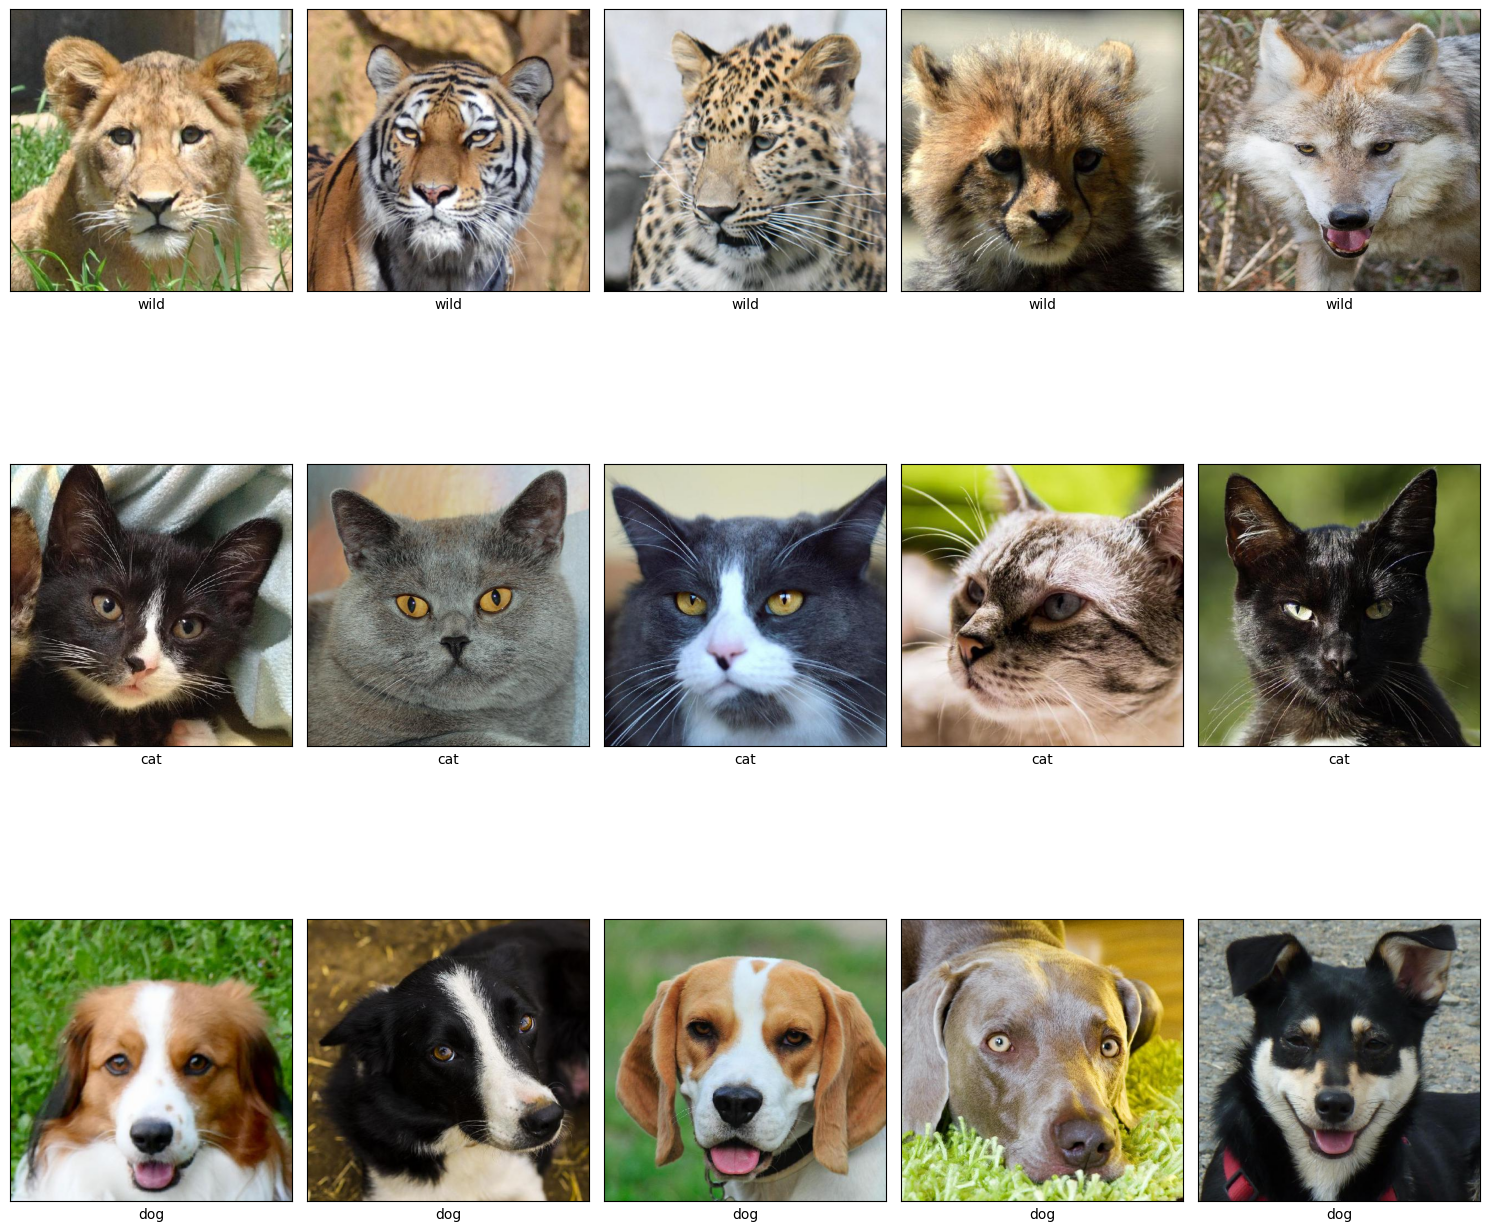

In [ ]:
# Buat dictionary untuk menyimpan nama file gambar per kelas
lung_image = {}

path = "/content/folder_dataset"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan 5 gambar acak dari masing-masing kelas
path = "/content/folder_dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        axs[i, j].imshow(imread(img_path))
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

### Plot distribusi gambar di seluruh kelas

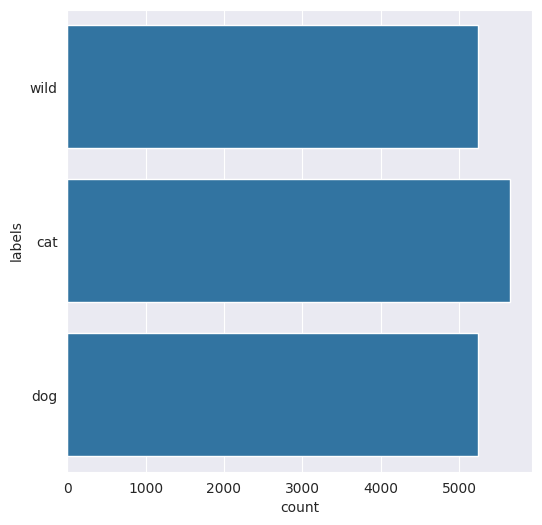

In [ ]:
# Define source path
lung_path = "/content/folder_dataset"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/folder_dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
cat     5653
dog     5239
wild    5238
dtype: int64

### Mengetahui Resolusi Gambar

In [ ]:
# Fungsi untuk mengambil data gambar, resolusi, dan rasio aspek
def create_image_dataset(path):
    # Fungsi untuk ambil resolusi gambar
    def get_image_resolution(filepath):
        try:
            with Image.open(filepath) as img:
                return img.size  # (width, height)
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
            return (0, 0)

    data = []

    # Loop semua file dalam folder
    for filename in os.listdir(path):
        if os.path.isfile(os.path.join(path, filename)) and filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(path, filename)
            # Ambil label dari nama file (misalnya 'carrot_001.jpg' → 'carrot')
            label = filename.split('_')[0]
            resolution = get_image_resolution(filepath)
            width, height = resolution
            aspect_ratio = width / height if height != 0 else 0

            data.append({'filename': filename, 'filepath': filepath, 'label': label,
                         'width': width, 'height': height, 'aspect_ratio': aspect_ratio})

    # Membuat DataFrame
    dataset_df = pd.DataFrame(data)

    return dataset_df

# Path ke folder dataset
path = "/content/dataset"

# Memanggil fungsi untuk membuat dataset
dataset_df = create_image_dataset(path)

# Tampilkan DataFrame
dataset_df.head()

filename                                      filepath  \
0  wild_flickr_wild_003164.jpg  /content/dataset/wild_flickr_wild_003164.jpg   
1  wild_flickr_wild_003667.jpg  /content/dataset/wild_flickr_wild_003667.jpg   
2   cat_pixabay_cat_002896.jpg   /content/dataset/cat_pixabay_cat_002896.jpg   
3  wild_flickr_wild_003922.jpg  /content/dataset/wild_flickr_wild_003922.jpg   
4   dog_pixabay_dog_001621.jpg   /content/dataset/dog_pixabay_dog_001621.jpg   

  label  width  height  aspect_ratio  
0  wild    512     512           1.0  
1  wild    512     512           1.0  
2   cat    512     512           1.0  
3  wild    512     512           1.0  
4   dog    512     512           1.0

In [ ]:
# Gabungkan width dan height jadi satu tuple untuk resolusi
dataset_df['resolution'] = list(zip(dataset_df['width'], dataset_df['height']))

# Hitung frekuensi setiap resolusi
res_count = dataset_df['resolution'].value_counts()

# Tampilkan
res_count

resolution
(512, 512)    16130
Name: count, dtype: int64

## Data Preprocessing

### Data Augmentation

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.resize(img, (224, 224))
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    return blurred

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "/content/dataset"  # Path for the original image
augmented_path = "animal/dataset_augmented"  # Path to put the augmented image
images = []  # To save images that have been preprocessed from the folder

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

Streaming output truncated to the last 5000 lines.
Could not read or process the image /content/dataset/wild_flickr_wild_002959.jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image /content/dataset/wild_flickr_wild_002763.jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image /content/dataset/cat_pixabay_cat_004749.jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image /content/dataset/cat_pixabay_cat_003627.jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image /content/dataset/wild_flickr_wild_002416.jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image /content/dataset/wild_flickr_wild_003534.jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image /content/dataset/dog_

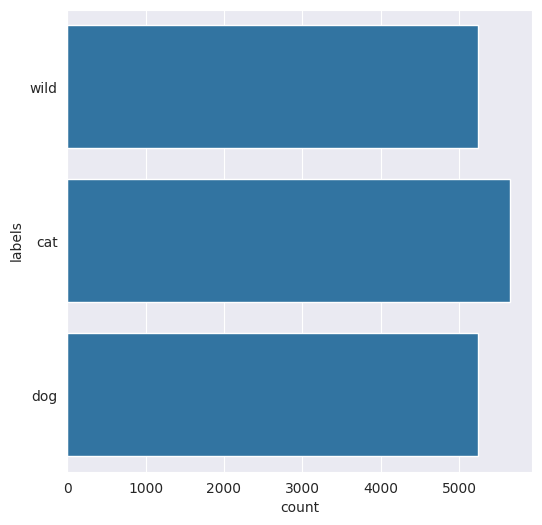

In [ ]:
# Define source path
lung_path = '/content/folder_dataset'

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset : Training and Testing

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/folder_dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
cat     5653
dog     5239
wild    5238
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
# X: filepath gambar, y: label
X = dataset_df['filepath']
y = dataset_df['label']

# train+val vs test (20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=300)

# train vs val dari sisa 80% data (25% dari 80% = 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=300)

In [ ]:
# Membuat DataFrame untuk data training, testing, dan validation
df_train = pd.DataFrame({'filepath':X_train,'label':y_train,'set':'train'})
df_test = pd.DataFrame({'filepath':X_test,'label':y_test,'set':'test'})
df_val = pd.DataFrame({'filepath':X_val,'label':y_val,'set':'val'})

In [ ]:
# Menampilkan ukuran data training, testing, dan validation
print('train size', len(df_train))
print('test size', len(df_test))
print('val size', len(df_val))

train size 9678
test size 3226
val size 3226


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)

print(df_all.groupby(['set', 'label']).size(), '\n')

# Cek sample data
df_all.sample(5)

set    label
test   cat      1130
       dog      1048
       wild     1048
train  cat      3392
       dog      3143
       wild     3143
val    cat      1131
       dog      1048
       wild     1047
dtype: int64 



filepath label   set
15564   /content/dataset/dog_pixabay_dog_000138.jpg   dog   val
11069  /content/dataset/wild_flickr_wild_002168.jpg  wild  test
11523   /content/dataset/cat_pixabay_cat_003046.jpg   cat  test
10225   /content/dataset/cat_pixabay_cat_003243.jpg   cat  test
13028    /content/dataset/dog_flickr_dog_000430.jpg   dog   val

In [ ]:
# Menentukan path untuk dataset asli dan dataset yang telah dibagi
datasource_path = "/content/dataset/"  #Path dataset asli
dataset_path = "/content/Dataset-Final/"  #Path dataset final

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['filepath']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'], row['label'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['label']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['label'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

In [ ]:
# Define training and test directories
train_dir = "Dataset-Final/train/"
test_dir = "Dataset-Final/test/"
val_dir = "Dataset-Final/val/"

In [ ]:
def animal_faces_model():
    # Custom Callback
    class StopAtTargetAccuracy(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
                print("\n\n Target akurasi tercapai. Menghentikan training...\n")
                self.model.stop_training = True

    # Callback list
    def callback_model():
        return [
            EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                verbose=1
            ),
            StopAtTargetAccuracy()
        ]

    TRAIN_DIR = 'Dataset-Final/train'
    VAL_DIR = 'Dataset-Final/val'
    TEST_DIR = 'Dataset-Final/test'

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    num_classes = train_generator.num_classes

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=50,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=callback_model(),
        verbose=1
    )

    return model, history


In [ ]:
model, history = animal_faces_model()

Found 9678 images belonging to 3 classes.
Found 3226 images belonging to 3 classes.
Found 3226 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 1153s 4s/step - accuracy: 0.4138 - loss: 1.0359 - val_accuracy: 0.8438 - val_loss: 0.3849 - learning_rate: 0.0010
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 1203s 4s/step - accuracy: 0.7988 - loss: 0.4946 - val_accuracy: 0.9299 - val_loss: 0.2009 - learning_rate: 0.0010
Epoch 3/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 1164s 4s/step - accuracy: 0.8908 - loss: 0.2999 - val_accuracy: 0.9526 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 1144s 4s/step - accuracy: 0.9190 - loss: 0.2245 - val_accuracy: 0.9575 - val_loss: 0.1225 - learning_rate: 0.0010
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 1161s 4s/step - accuracy: 0.9339 - loss: 0.1801 - val_accuracy: 0.9479 - val_loss: 0.1414 - learning_rate: 0.0010
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 1202s 4s/step - accuracy: 0.9475 - loss: 0.1510 - val_accuracy: 0.9659 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 7/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9552 - loss

## Evaluasi dan Visualisasi

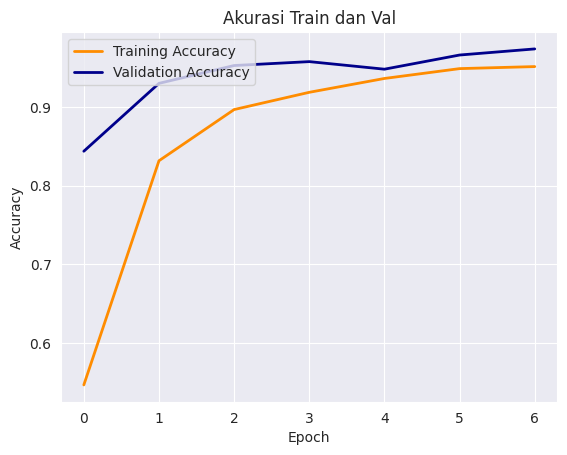

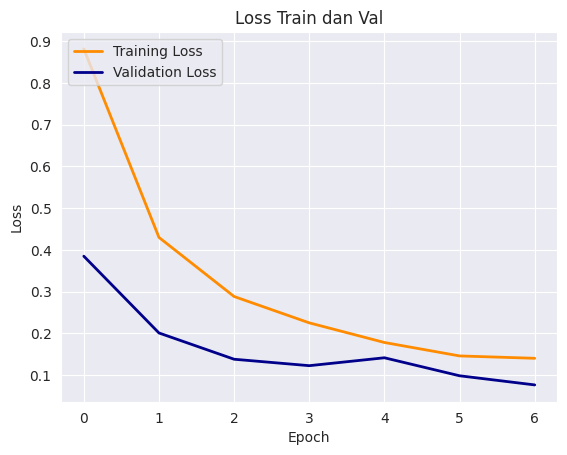

In [ ]:
# Mengambil data akurasi dan loss dari hasil pelatihan
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat range epoch
epoch_range = range(len(train_accuracy))

# Visualisasi akurasi
plt.plot(epoch_range, train_accuracy, color='darkorange', label='Training Accuracy', linewidth=2)
plt.plot(epoch_range, val_accuracy, color='darkblue', label='Validation Accuracy', linewidth=2)
plt.title('Akurasi Train dan Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Visualisasi loss
plt.plot(epoch_range, train_loss, color='darkorange', label='Training Loss', linewidth=2)
plt.plot(epoch_range, val_loss, color='darkblue', label='Validation Loss', linewidth=2)
plt.title('Loss Train dan Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Konversi Model

### Saved Model

In [ ]:
model.export('saved_model')
shutil.make_archive('saved_model', 'zip', 'saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132248819263504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819261584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819259472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819261200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819265232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819257744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819258128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819258512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819256016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819255248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132248819254864: Te

'/content/saved_model.zip'

### Tensorflow lite (tflite)

In [ ]:
# Konversi dari direktori SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Simpan model TFLite
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
class_labels = ["cat", "dog", "wild"]

with open('label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

### Tfjs_model

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/tfjs_model

2025-04-22 13:46:11.745250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745329572.215419   62455 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745329572.336332   62455 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-22 13:46:26.598357: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745329586.768420   62455 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)

Saving kuceng.jpg to kuceng (4).jpg
cat             : 95.29%
dog             : 0.16%
wild            : 4.55%


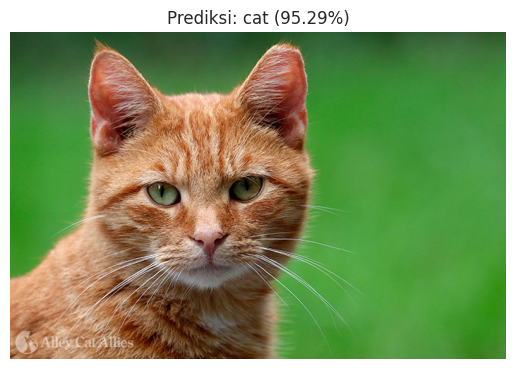

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

# Upload gambar dari lokal
uploaded = files.upload()
image_path = next(iter(uploaded))

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Ambil info input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load label kelas
with open('label.txt', 'r') as f:
    labels = f.read().splitlines()

# Prediksi + Probabilitas
def predict_image_with_probs(image_path):
    img = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]  # ambil batch pertama
    return output_data

# Lakukan prediksi
probs = predict_image_with_probs(image_path)

# Hasil
for label, prob in zip(labels, probs):
    print(f"{label:<15} : {prob:.2%}")

# === Visualisasi gambar dan prediksi tertinggi ===
img = Image.open(image_path)
predicted_index = np.argmax(probs)
predicted_label = labels[predicted_index]
confidence = probs[predicted_index]

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {predicted_label} ({confidence:.2%})")
plt.show()

Saving popoy.jpg to popoy.jpg
cat             : 0.17%
dog             : 91.97%
wild            : 7.86%


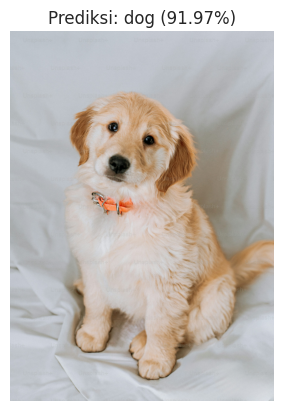

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

# Upload gambar dari lokal
uploaded = files.upload()
image_path = next(iter(uploaded))

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Ambil info input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load label kelas
with open('label.txt', 'r') as f:
    labels = f.read().splitlines()

# Prediksi + Probabilitas
def predict_image_with_probs(image_path):
    img = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]  # ambil batch pertama
    return output_data

# Lakukan prediksi
probs = predict_image_with_probs(image_path)

# Hasil
for label, prob in zip(labels, probs):
    print(f"{label:<15} : {prob:.2%}")

# === Visualisasi gambar dan prediksi tertinggi ===
img = Image.open(image_path)
predicted_index = np.argmax(probs)
predicted_label = labels[predicted_index]
confidence = probs[predicted_index]

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {predicted_label} ({confidence:.2%})")
plt.show()

Saving awuuu.jpg to awuuu.jpg
cat             : 0.01%
dog             : 4.29%
wild            : 95.70%


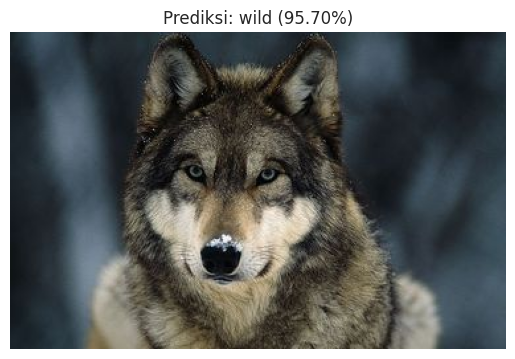

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

# Upload gambar dari lokal
uploaded = files.upload()
image_path = next(iter(uploaded))

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Ambil info input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load label kelas
with open('label.txt', 'r') as f:
    labels = f.read().splitlines()

# Prediksi + Probabilitas
def predict_image_with_probs(image_path):
    img = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]  # ambil batch pertama
    return output_data

# Lakukan prediksi
probs = predict_image_with_probs(image_path)

# Hasil
for label, prob in zip(labels, probs):
    print(f"{label:<15} : {prob:.2%}")

# Visualisasi gambar
img = Image.open(image_path)
predicted_index = np.argmax(probs)
predicted_label = labels[predicted_index]
confidence = probs[predicted_index]

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {predicted_label} ({confidence:.2%})")
plt.show()

## Requirement

In [68]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.14.0.37.22
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
communi